1. 파이토치로 ImageNet 데이터셋에서 학습된 모델을 로드할 수 있다.
2. VGG모델을 이해한다.
3. 입력 화상의 크기와 색상을 변환할 수 있다.

In [1]:
# 패키지 import
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

# 파이토치 버전 확인
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version:", torch.__version__)

PyTorch Version:  1.12.1+cu102
Torchvision Version: 1.12.1+cu102


In [2]:
# VGG-16 모델의 인스턴스 생성
use_pretrained = True # 학습된 파라미터 사용
net = models.vgg16(pretrained=use_pretrained)
net.eval() # 추론 모드(평가 모드)로 설정

# 모델의 네트워크 구성 출력
print(net)

/home/kimdonguk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kimdonguk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

출력 결과를 보면 VGG-16 모델의 네트워크 구성은 features와 classifiers라는 두 모듈로 나누어졌습니다. 그리고 각 모듈 속에 합성곱 층과 전결합 층이 있습니다.

VGG-16은 이름처럼 16층이 아닌 총 38층으로 구성되어 있습니다. 16층이란 합성곱 층과 전결합 층의 수를 나타냅니다(활성화 함수ReLU, pooling층, dropout층은 포함하지 않습니다).

![image](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbNHvRX%2FbtqCUbC9ZWU%2FrnK2pKGlkOShnIOlrPxbz1%2Fimg.png)

입력 화상의 크기는 RGB 색상 채널 3, 높이와 너비가 224 픽셀이므로 (batch_num, 3, 224,224)가 됩니다. batch_num은 미니 배치와 사이즈를 나타내며 그림에서는 배치의 차원을 생략했습니다.

In [3]:
class BaseTransform():
    """
    화상 크기 변경 및 색상 표준화

    Attributes
    ----------
    resize : int
        크기 변경 전의 화상 크기
    mean : (R, G, B)
        각 색상 채널의 평균값
    std : (R, G, B)
        각 색상 채널의 표준편차
    """

    def __init__(self, resize, mean, std):
        self.base_transform= transforms.Compose([
            transforms.Resize(resize), # 짧은 변의 길이가 resize 크기가 된다
            transforms.CenterCrop(resize), # 화상 중앙을 resize x resize로 자른다.
            transforms.ToTensor(), # 토치 텐서로 변환
            transforms.Normalize(mean, std) # 색상 정보의 표준화
            ])

    def __call__(self, img):
        return self.base_transform(img)

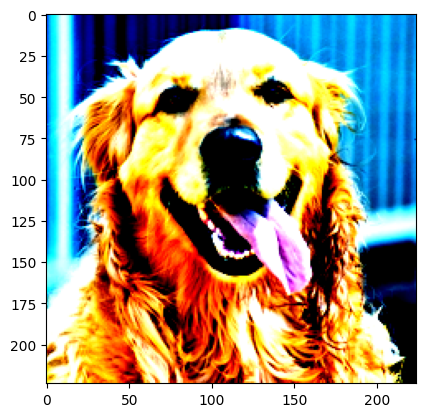

In [4]:
# 화상 전처리 확인

# 1. 화상 읽기
image_file_path = '/home/kimdonguk/바탕화면/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [색상][높이][너비]  [높이][너비][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show

# 3. 화상 전처리 및 처리된 화상의 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) # torch.Size([3,224,224])

# (색상,높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한하여 표시
img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [5]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('/home/kimdonguk/바탕화면/pytorch_advanced/1_image_classification/data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

VGG-16모델의 1000차원 출력을 라벨명으로 변환하는 ILSVRCPredictor 클래스를 만듭니다. ILSVRC의 라벨명은 사전에 준비한 JSON 파일인 imagenet_class_index.json을 사용합니다.

VGG-16모델로 출력된 값은 torch.Size([1,1000]) 크기의 파이토치 텐서 형식입니다. 이를 넘파이형 변수로 변환합니다. 먼저 출력 값을 네트워크에서 분리하는 .detach()를 적용합니다.

이를 maxid=np.argmax(out.detach().numpy())처럼 한 줄로 표현합니다. 이후에는 maxid에 해당하는 라벨명을 딕셔너리 ILSVRC_class_index에서 얻습니다.

In [6]:
# 출력 결과에서 라벨을 예측하는 후처리 클래스
class ILSVRCPredictor():
    """
    ILSVRC 데이터 모델의 출력에서 라벨을 구한다.

    Attributes
    ----------
    class_index : dictionary
            클래스 index와 라벨명을 대응시킨 사전형 변수
    """

    def __init__(self, class_index):
        self.class_index = class_index
    
    def predict_max(self, out):
        """
        최대 확률의 ILSVRC 라벨명을 가져온다.

        Parameters
        ----------
        out: torch.Size([1,1000])
            net에서 출력
        
        Returns
        -------
        predicted_label_name : str
            가장 예측 확률이 높은 라벨명
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name


![Image](https://lh3.googleusercontent.com/4B2JQaEhQE8IrB01ZrBCek_YEYR8WW5YN7LAw-o6uRq_FP1o1QB1nOE5_B_MjMu1E4ybw66ZeM0QIIzP73cuKcUTUY4nySAVTB8L8ChW3_JZx7uolpo24g-0wV2S7ZtrLhdp_wju=s0)

입력 화상이 BaseTransform 클래스로 변환되어 VGG-16 모델에 입력됩니다. 모델에서 1000차원의 출력은 ILSVRCPredictor 클래스로 가장 예측 확률이 높은 라벨명으로 반환되어 최종 예측 결과가 출력됩니다.

이러한 흐름을 구현하여 학습된 VGG모델로 화상을 예측합니다. 파이토치 네트워크에 화상을 입력할 때 데이터를 미니 배치 형태로 해야 합니다. unsqueeze_(0)을 사용하여 입력 데이터에 미니 배치의 차원을 추가합니다.

In [7]:
# ILSVRC 라벨 정보를 읽어 사전형 변수 생성
ILSVRC_class_index = json.load(open('/home/kimdonguk/바탕화면/pytorch_advanced/1_image_classification/data/imagenet_class_index.json', 'r'))

# ILSVRCPredictor 인스턴스 생성
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 입력 화상 읽기
image_file_path = '/home/kimdonguk/바탕화면/pytorch_advanced/1_image_classification/data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [높이][너비][색RGB]

# 전처리 후 배치 크기의 차원 추가
transform = BaseTransform(resize, mean, std) # 전처리 클래스 작성
img_transformed = transform(img)
inputs = img_transformed.unsqueeze_(0) # torch.Size([1, 3, 224, 224])

# 모델에 입력하고 모델 출력을 라벨로 변환
out = net(inputs) # torch.Size([1,1000])
result = predictor.predict_max(out)

# 예측 결과 확인
print("입력 화상의 예측 결과: ", result)

입력 화상의 예측 결과:  golden_retriever
